<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="height:100px; display: inline"  alt="INSA"/></a> 
<a href="https://observatoire-ia.ulaval.ca/" ><img src="https://observatoire-ia.devbeet.com/app/uploads/2019/06/oia-share.png" style="height:100px; display: inline" alt="ObvIA"/></a> 
<a href="https://aniti.univ-toulouse.fr/" ><img src="https://www.actuia.com/wp-content/uploads/2019/07/logo_ANITI1-696x348.jpg" style="height:100px; display: inline" alt="ANITI"/></a> 

# Tutoriel: Détecter, Mesurer, Expliquer, Atténuer, la Discrimination Indirecte des Algorithmes d'Apprentissage Statistique de l'IA


**Résumé**
Analyse de données extraites d'un recensement aux USA de 1994 et disponibles sur le [dépôt de l'UCI](http://archive.ics.uci.edu/ml/). Elles permettent de mettre en relation le niveau de revenu (inférieur ou supérieur à 50k$), analogue à une "solvabilité" ou score de crédit, avec d'autres variables dont certaines sensibles car indiquant l'appartenance à un groupe protégé par la loi: sexe, origine ethnique. Différents indicateurs de biais donc de sources de discrimination indirecte vis à vis d'un groupe, sont définis et illustrés sur ces données. Les principaux, consensuels dans la littérature, sont l'effet disproportionné ou *disparate / adverse impact* (DI) (*demographic equality*), le taux d'erreur conditionnel (*overall error equality*) et des mesures associées à l'asymétrie des matrices de confusion conditionnellement au groupe (*equalized odds*); ce premier tutoriel cible la détection de discriminaiton indirecte principale associée à l'effet diproportionné (*adverse* ou *disparate impact*). Les résultats montrent que les biais de société présents dans les données d'entraînement sont fidèlement reproduits par l'apprentissage et même renforcés. C'est typiquement un cas de discrimination notamment avec une régression logistique linéaire, pas significativement avec un algorithme non linéaire (*random forest*). La doctrine "officielle" des enquêtes par *testing*, adaptées à détecter une discrimination individuelle directe, sous-estiment gravement la discrimination de groupe indirecte. L'utilisation d'algorithmes non linéaires (arbre ou forêt aléatoire) spécifiques, un par classe: femmes *vs.* hommes, annule l'effet discriminatoire. Il est ensuite facile d'introduire une part de discrimination postive pour atténuer le biais de société sans pénaliser la qualité de prévision. Enfin d'autres types de biais ou discriminaiton sont considérés. Cela montre que ces données que les taux d'erreur pour les femmes sont sensiblement moins élevés. Ce n'est que très apparemment à leur avantage car l'étude du 3ème niveau de biais montre uneforte asymétrie des matrices de confusion qui change avec le genre: plus d'erreurs pour les hommes mais à leur avantage car avec des taux de faux positifs plus élevés et des taux de faux négatifs moins élevés. 

***NB*** Tout *data scientist* dispose d'une large marge de manoeuvre sur ces sujets en fonction de ses compétences, de sa déontologie ou éthique professionnelle, et sans contrôle externe à ce jour, malgré les souhaits du rapport Villani (2018) de mise en place d'un *Discriminaiton Impact Assessment*. 

***Rappel*** Toutes les législations européennes, américaines, canadiennes... interdisent les discriminations, directes et indirectes; le code pénal français prévoit des peines allant jusqu'à 45k€ d'amende et trois ans de prison.

## Introduction
### Les données
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Les deux fichiers *train* et *test* on été réunis en un seul. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage. L’objectif est de prévoir, avec plus ou moins de biais, la variable binaire "revenu annuel" supérieur ou inférieur à 50k$. Cette prévision n'impacte pas la personne mais comme la démarche et le contexte sont tout à fait similaires à ce que pourrait faire une banque pour évaluer un risque de crédit, c'est exemple est très illustratif. Ce jeu de données est systématiquement utilisé (bac à sable) pour évaluer les propriétés des algorithmes d'apprentissage équitable ou loyal (*fair learning*) car, contrairement à beaucoup d'autres jeux de données utilisés pour cette fin (*e.g. german credit bank*), la vraie valeur de la variable cible est connue ainsi que l'origine ethnique des personnes concernées.

Dans les données initiales, 48.842 individus sont décrits par les 14 variables du tableau ci-dessous:


|Num|Libellé|Ensemble de valeurs|
|-|---------:|-------------------:|
|1|`Age`|real|
|2|`workClass`|Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked|
|3|`fnlwgt`|real|
|4|`education`|Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool|
|5|`educNum`|integer|
|6|`mariStat`|Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|7|`occup`|Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces|
|8|`relationship`|Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
|9|`origEthn`|White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black|
|10|`sex`|Female, Male|
|11|`capitalGain`|real| 
|12|`capitalLoss`|real|
|13|`hoursWeek`|real|
|14|`nativCountry`|United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands|
|15|`income`|>50K, <=50K|


### Préparation des données

Le traitement commence par une préparation détaillée des données:
- lecture et prise en charge des données en remarquant que la variable `fnlwgt` (Final sampling weight) a un [statut particulier](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) pas très clair; elle est éliminée;
- suppression des observations présentant des données manquantes, erreurs ou incohérences,
- regroupement des modalités très dispersées, 
- suppression des variables redondantes. 

Cette phase est notoirement différente de la stratégie de Friedler et al. (2019) qui, par principe, analysent les données brutes.

### Estimation des biais

Parmi tous les critères de biais existant susceptibles de mettre en évidence une discrimination indirecte (Zliobaitė, 2015)), trois ont été privilégiés (cf. Vermat et Rubin, 2018): 
1. discrimination indirecte par l'effet disproportionné: *disparate impact* ou *demographic equality*
2. comparaison des taux d'erreur conditionnels: *overall error equality*
3. comparaison des rapports de cote: *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds*.

L'accent est mis dans ce premier tutoriel sur l'estimation de l'effet disproportionné (*disparate* ou *adverse impact*) vis-à-vis du sexe. L'approximation de l'intervalle de confiance (*delta method* Besse et al. 2018) est comparée avec une estimation *bootstrap* conduisant aux mêmes résutlats. Les estimations sont calculées sur les données initiales de la base (biais de société) puis sur les prévisions du seuil de revenu obtenues par deux algorithmes (régression logistique et forêts aléatoires) pour évaluer le risque de discrimination. Les estimations par intervalle de confiance des deuxautres critères de discrimination sont également disponibles.

Le deuxième tutoriel cible les deux autres types de de biais.

### Biais et discriminations
Les résultats obtenus montrent clairement le renforcement du biais opéré par un modèle linéaire contrairement à un algorithme non linéaire. De plus, la suppression de la variable sensible du modèle de prévision n'a qu'un effet négligeable sur l'effet discriminatoire d'un algorithme; en conséquence, le testing devient inefficace pour détecter une discrimination. Les résultats montrent donc l'importance de la prise en compte des interactions et qu'une correction élémentaire du biais voire l'introduction d'une discrimination positive peut être facilement obtenue sans nuire à la précision de la prévision.

*Remarques*: 
- un [calepin plus détaillé](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) mais plus long propose une comparaison des impacts des autres algorithmes d'apprentissage et donc de leur effet discriminatoire fonction du biais de société (sexe et origine ethnique). Cela permet d'en mieux comprendre les origines selon le déséquilibre des classes et surtout selon l'importance des interactions entre les variables. 
- le site [aif360](https://aif360.mybluemix.net/) propose également un ensemble d'exemples et tutoriels. Il est nettement plus riche: autres jeux de données, autes critères et surtout plus d'algorithmes de débiaisage, mais présente soit des démonstrations triviales soit des exemples des méthodes très sophistiquées d'atténuation du biais.   Ce tutoriel se veut plus pédagogique pour appréhender pas à pas les problèmes. 

## Exploration des données
### Lecture et premières transformations
La lecture et la transformation des données brutes du dépôt de l'UCI sont obtenues directement en exécutant un code source en R. Consulter le code du programme pour comprendre les transformations qui ont été réalisées sur les données brutes. Cette étape peut être rendue plus efficace (programme plus concis et exécution plus rapide) en utilisant la librairie `dplyr` très adaptée à cet usage amis de syntaxe plus complexe.

Charger les données et le programme dans le répertoire courant en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

In [1]:
source("dataPrepAdultCensus.R")
summary(dataBase)

      age                workClass         fnlwgt              education    
 Min.   :18.00   Federal-Govt : 1390   Min.   :  13492   HS-grad    :14766  
 1st Qu.:28.00   Not-Working  :   21   1st Qu.: 117404   HS-Graduate: 9892  
 Median :37.00   Other-Govt   : 5023   Median : 178390   Bachelors  : 7569  
 Mean   :38.79   Private      :32856   Mean   : 189858   Dropout    : 5182  
 3rd Qu.:47.00   Self-Employed: 5425   3rd Qu.: 237998   Associates : 3466  
 Max.   :90.00                         Max.   :1490400   Masters    : 2512  
                                                         (Other)    : 1328  
    educNum               mariStat              occup      
 Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:13.00                         Sales       : 5272  
 Max.   :16.00          

### Description statistique élémentaire
Mettre en évidence des difficultés présentes sur certaines variables ou couples de variables.

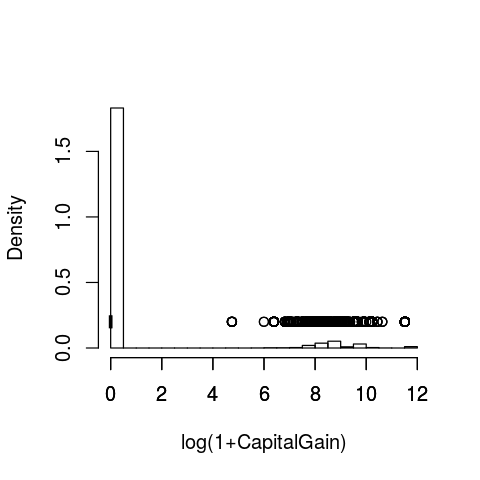

In [2]:
options(repr.plot.width=4, repr.plot.height=4)
hist(dataBase[,"LcapitalGain"],probability=T, main="",xlab="log(1+CapitalGain)")
boxplot(dataBase[,"LcapitalGain"], horizontal=TRUE,boxwex=.2,  outline=TRUE,  
        frame=F, col = "lightgrey", add = TRUE,at=0.2)

Nécessité de transformer certaines variables avant de contruire des modèles linéaires puis mise en évidence d'incohérences et de fortes redondances entre certaines variables.

In [3]:
table(dataBase$relationship,dataBase$sex)   

                
                 Female  Male
  Husband             1 18659
  Not-in-family    5404  6274
  Other-relative    599   721
  Own-child        2707  3477
  Unmarried        3649  1133
  Wife             2090     1

In [4]:
table(dataBase$education,dataBase$educNum)  

             
                  1     2     3     4     5     6     7     8     9    10    11
  Associates      0     0     0     0     0     0     0     0     0     0  1959
  Bachelors       0     0     0     0     0     0     0     0     0     0     0
  Doctorate       0     0     0     0     0     0     0     0     0     0     0
  Dropout        72   222   446   819   644  1073  1387   519     0     0     0
  HS-grad         0     0     0     0     0     0     0     0 14766     0     0
  HS-Graduate     0     0     0     0     0     0     0     0     0  9892     0
  Masters         0     0     0     0     0     0     0     0     0     0     0
  Prof-School     0     0     0     0     0     0     0     0     0     0     0
             
                 12    13    14    15    16
  Associates   1507     0     0     0     0
  Bachelors       0  7569     0     0     0
  Doctorate       0     0     0     0   544
  Dropout         0     0     0     0     0
  HS-grad         0     0     0 

In [5]:
table(dataBase$mariStat,dataBase$relationship)

               
                Husband Not-in-family Other-relative Own-child Unmarried  Wife
  Married         18660            19            184       125         0  2091
  Never-Married       0          6667            793      5423      1217     0
  Not-Married         0          4305            284       616      3054     0
  Widowed             0           687             59        20       511     0

In [6]:
table(dataBase$origEthn,dataBase$nativCountry)

             
              British-Commonwealth China Euro_1 Euro_2 Latin-America Other
  Amer-Indian                    0     1      1      2            12     0
  Asian                        125   185      4    101            13    61
  Black                         11     0     10      0           230     8
  Other                         12     0      2      1           125    11
  White                        333    10    313    229          1157   198
             
              SE-Asia South-America United-States
  Amer-Indian       1             1           410
  Asian           416             0           397
  Black             4             2          3929
  Other             0            31           166
  White            20           278         35905

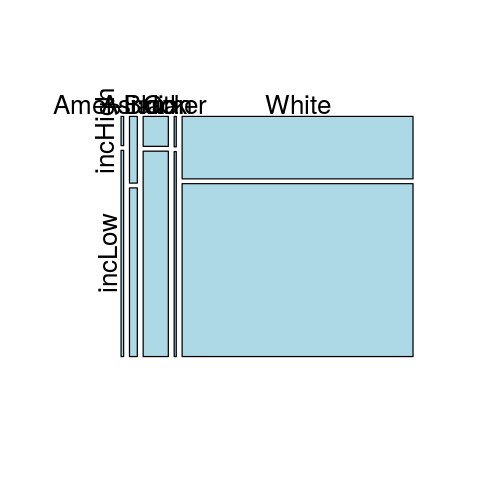

In [7]:
mosaicplot(table(dataBase[,"origEthn"],dataBase[,"income"]),main="", col="lightblue",cex=1.3)

Quelques modifications sont apportées de la base; des variables sont supprimées afin de ne garder qu'une seule présence d'une information sensible: sexe et origine ethnique.
- Suppression de la variable 3 `fnlwgt` qui n'a guère de signification pour cette analyse.
- Création d'une variable binaire `Child`: présence ou non d'enfants.
- Suppression de la variable 8 `relationship` redondante avec le sexe et le statut marital,
- Suppression de la variable 14 `nativCountry` redondante avec l'origine ethnique.
- La variable 9 `originEthn` est simplifiée à 2 classes: CaucYes *vs.* CaucNo

**Attention** Pour la suite, il est important que les niveaux des facteurs soient ordonnés de façon cohérente pour la bonne interprétation des tables de contingence et de leurs effectifs. Par convention, les modalités pré-jugées socialement "dévavorables": revenu faible, femme, non caucasien (codées 0), précèdent les autres: revenu élevé, homme, caucasien (codées 1). Il faut donc soit réordonner les niveaux de la variable `income` ou renommer les modalités pour faire correspondre l'ordre alphabétique; ce deuxième choix est exécuté.

In [8]:
dataBase[,"child"]=as.factor(ifelse(dataBase$relationship=='Own-child',"ChildYes","ChildNo"))
dataBase[,"origEthn"]=as.factor(ifelse(dataBase$origEthn %in% c('Amer-Indian','Asian','Black','Other'),"CaucNo","CaucYes"))
dataBase[,"income"]=as.factor(ifelse(dataBase$income=='incLow',"incB","incH"))
datBas=dataBase[,-c(3,8,14)]
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

Quelques *mosaicplots* basiques montrent le liens des variables sensibles avec la cible (seuil de revenu) et mettent clairement en évidence le biais de société.

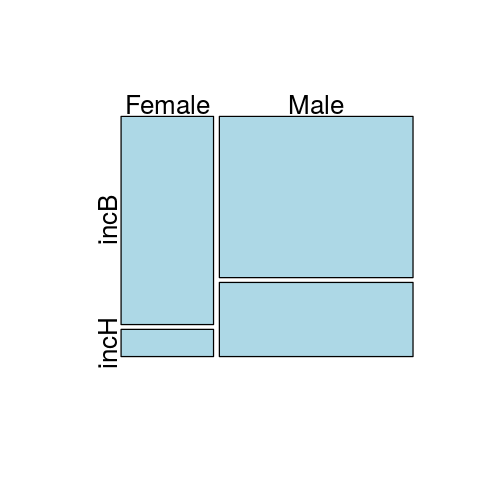

In [9]:
mosaicplot(table(datBas[,"sex"],datBas[,"income"]),main="", col="lightblue",cex=1.3)

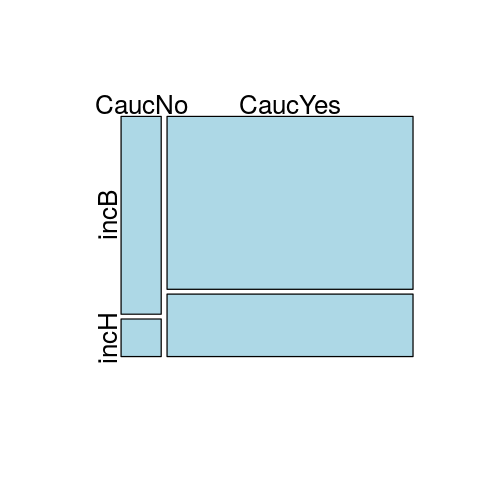

In [10]:
mosaicplot(table(datBas[,"origEthn"],datBas[,"income"]),main="",col="lightblue",cex=1.3)

**Q** Commentaires sur les biais présent dans la base, les déséquilibres des classes.

Le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb) propose l'exécution d'une [analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf) afin de représenter globalement la structure des liaisons entre les variables; c'est la raison pour laquelle les variables quantitatives ont été découpées en classes. Comme l'AFCM n'est pas reprise ici par souci de concision, ces variables sont abandonnées par la suite.

### Préparation des échantillons
La base de données est divisée en deux échantillons d'apprentissage et de test.

In [11]:
summary(datBas)

      age                workClass           education        educNum     
 Min.   :18.00   Federal-Govt : 1390   HS-grad    :14766   Min.   : 1.00  
 1st Qu.:28.00   Not-Working  :   21   HS-Graduate: 9892   1st Qu.: 9.00  
 Median :37.00   Other-Govt   : 5023   Bachelors  : 7569   Median :10.00  
 Mean   :38.79   Private      :32856   Dropout    : 5182   Mean   :10.16  
 3rd Qu.:47.00   Self-Employed: 5425   Associates : 3466   3rd Qu.:13.00  
 Max.   :90.00                         Masters    : 2512   Max.   :16.00  
                                       (Other)    : 1328                  
          mariStat              occup          origEthn         sex       
 Married      :21079   Admin       : 5501   CaucNo : 6272   Female:14450  
 Never-Married:14100   Blue-Collar :14732   CaucYes:38443   Male  :30265  
 Not-Married  : 8259   Other-occups: 2391                                 
 Widowed      : 1277   Professional: 5992                                 
                       Sa

In [12]:
datBas=datBas[,c("age","educNum","mariStat","occup","origEthn",
                 "sex","hoursWeek","income","LcapitalGain","LcapitalLoss","child")]
summary(datBas)
write.csv(datBas,file="adultBase-R.csv",row.names = FALSE)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :21079   Admin       : 5501  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:14100   Blue-Collar :14732  
 Median :37.00   Median :10.00   Not-Married  : 8259   Other-occups: 2391  
 Mean   :38.79   Mean   :10.16   Widowed      : 1277   Professional: 5992  
 3rd Qu.:47.00   3rd Qu.:13.00                         Sales       : 5272  
 Max.   :90.00   Max.   :16.00                         Service     : 4846  
                                                       White-Collar: 5981  
    origEthn         sex          hoursWeek      income       LcapitalGain   
 CaucNo : 6272   Female:14450   Min.   : 1.00   incB:33511   Min.   : 0.000  
 CaucYes:38443   Male  :30265   1st Qu.:40.00   incH:11204   1st Qu.: 0.000  
                                Median :40.00                Median : 0.000  
                                Mean   :41.17                Mean   : 0.747  
  

In [13]:
set.seed(11) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(datBas) # nombre de lignes dans les données
nvar=ncol(datBas) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio) 
# indices de l'échantillon test
testi=sample(1:npop,ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop,testi) 

In [14]:
# construction de l'échantillon d'apprentissage
datApp=datBas[appri,]
# construction de l'échantillon test 
daTest=datBas[testi,]
# sauvegarde des fichiers pour le deuxième tutoriel
write.csv(datApp,"datApp.csv")
write.csv(daTest,"daTest.csv")

Définition d'une fonction pour calculer le taux d'erreur usuel de la matrice de confusion. Avec l'ordonnancement des modalités, les bien classés sont les termes diagonaux de la matrice de confusion.

In [15]:
tauxErr=function(table){round((table[1,2]+table[2,1])/sum(table)*100,2)}

## Prévision du seuil de revenu 
Une comparaison détaillée (cf. le [tutoriel](https://github.com/wikistat/Apprentissage/blob/master/Adult-Census/Apprent-Python-AdultCensus.ipynb)) de la plupart des modèles et algorithmes de prévision du seuil de revenu en fonction des différentes variables met en évidence des résultats de prévision un peu meilleurs obtenus par l'algorithme de *gradient boosting* (version xtrem). Néanmoins, on peut se limiter ici à un choix plus restreint de modèles et algorithmes pour comprendre l'impact sur la discrimination.
- la régression logistique (linéaire) interprétable; 
- les forêts aléatoires (non linéaire) conduisent à une meilleure précision mais sans capacité d'interprétation.

### Prévision par [régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

In [16]:
# estimation du modèle complet
log.lm=glm(income~.,data=datApp,family=binomial)
# significativité des paramètres
anova(log.lm,test="Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,35771,40227.31,NA
age,1,1865.39750,35770,38361.91,0.000000e+00
educNum,1,4247.88595,35769,34114.03,0.000000e+00
mariStat,3,6299.40893,35766,27814.62,0.000000e+00
occup,6,792.03697,35760,27022.58,8.090064e-168
origEthn,1,19.96324,35759,27002.62,7.894531e-06
sex,1,51.34567,35758,26951.27,7.745273e-13
hoursWeek,1,439.60497,35757,26511.67,1.319533e-97
LcapitalGain,1,1239.63939,35756,25272.03,1.481393e-271
LcapitalLoss,1,304.08396,35755,24967.94,4.246522e-68


**Q** Commentaires sur la significativité des paramètres.

In [17]:
summary(log.lm)


Call:
glm(formula = income ~ ., family = binomial, data = datApp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8361  -0.5640  -0.2250  -0.0251   3.5922  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.945211   0.144327 -41.193  < 2e-16 ***
age                    0.023179   0.001442  16.071  < 2e-16 ***
educNum                0.285120   0.008336  34.205  < 2e-16 ***
mariStatNever-Married -2.432828   0.057391 -42.390  < 2e-16 ***
mariStatNot-Married   -2.115795   0.055039 -38.442  < 2e-16 ***
mariStatWidowed       -2.163944   0.130148 -16.627  < 2e-16 ***
occupBlue-Collar      -0.341925   0.063323  -5.400 6.67e-08 ***
occupOther-occups      0.382624   0.081347   4.704 2.56e-06 ***
occupProfessional      0.406026   0.068205   5.953 2.63e-09 ***
occupSales             0.126279   0.070264   1.797 0.072301 .  
occupService          -0.991774   0.102333  -9.692  < 2e-16 ***
occupWhite-Collar      0.655764   0.

**Q** Interprétation du rôle des variables sur le seuil de revenu.

In [18]:
# Prévision de l'échantillon test
pred.log=predict(log.lm,newdata=daTest,type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6154  950
  TRUE   526 1313

In [19]:
tauxErr(confMat)

[1] 16.5

**Remarque** Un modèle de régression logistique avec interactions, donc quadratique, ne conduit pas à une  prévision significativement meilleure mais nécessite une sélection de variables (*e.g. stepwise* ou `both`) longue à exécuter. Toujours par souci de concision, elle n'est pas reproduite; consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb).

### Prévision par [forêts aléatoires](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Q** Quelles sont les options par défaut utilisées ci-dessous?

In [20]:
summary(datApp)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :16819   Admin       : 4393  
 1st Qu.:28.00   1st Qu.: 9.00   Never-Married:11307   Blue-Collar :11764  
 Median :37.00   Median :10.00   Not-Married  : 6613   Other-occups: 1901  
 Mean   :38.81   Mean   :10.16   Widowed      : 1033   Professional: 4800  
 3rd Qu.:48.00   3rd Qu.:13.00                         Sales       : 4230  
 Max.   :90.00   Max.   :16.00                         Service     : 3891  
                                                       White-Collar: 4793  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 5001   Female:11553   Min.   : 1.00   incB:26831   Min.   : 0.0000  
 CaucYes:30771   Male  :24219   1st Qu.:40.00   incH: 8941   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :41.16                Mean   : 0.7468

In [21]:
help(randomForest)

In [22]:
library(randomForest)
rf.mod=randomForest(income~.,data=datApp)
pred.rf=predict(rf.mod,newdata=daTest,type="response")
confMat=table(pred.rf,daTest$income)
confMat
tauxErr(confMat)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


       
pred.rf incB incH
   incB 6292  870
   incH  388 1393

[1] 14.07

**Q** Comparer les résultats obtenus, précision et explicabilité.

Les calculs peuvent également être conduits en considérant l'origine ethnique comme variable sensible (consulter le [calepin plus complet](https://github.com/wikistat/Fair-ML-4-Ethical-AI/blob/master/AdultCensus/AdultCensus-R-biasDetectionLong.ipynb)) mais les résultats sont moins nets, moins "pédagogiques".

### Modèle de régression sans la variable sexe
Une approche très naïve pour construire un apprentissage "loyal" consiste à supprimer la variable sensible. Le modèle de régression logistique est donc estimé sans cette variable afin d'évaluer par la suite l'impact sur le biais.

In [23]:
# estimation du modèle 
log_g.lm=glm(income~.,data=datApp[,-6],family=binomial)

In [24]:
# Prévision
pred_g.log=predict(log_g.lm,newdata=daTest[,-8],type="response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
confMat=table(pred_g.log>0.5,daTest$income)
confMat

       
        incB incH
  FALSE 6157  953
  TRUE   523 1310

In [25]:
tauxErr(confMat)

[1] 16.5

**Q** que dire de la qualité de prévision sans la variable sexe?

## Estimation de l'effet disproportionné
### Définition
Les mesures de discrimination indirecte ou de groupe sont basées sur un critère d'effet disproportionné ou *disparate / adverse impact* (*DI*) apparu aux USA en 1971 (Barocas et Selbst, 2016) pour détecter des discriminations à l'embauche. Ce critère est défini par le rapport de deux probabilités. La probabilité de bénéficier d'une situation ou décision favorable (revenu élevé, crédit, emploi, logement...) pour une personne du groupe protégé par la loi: femme ou origine non caucasienne, sur la même probabilité pour une personne de l'autre groupe: homme ou origine caucasienne.

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici le revenu, $Y=1$ revenu élevé *vs* $Y=0$; 
- $g(X)=\hat{Y}$ le score élevé ou faible ou prévision du revenu, $g(X)=\hat{Y}=0$: prévision d'un revenu faible;
- $S$ est la variable sensible qui désigne le groupe en principe protégé par la loi contre une possible discrimination. Il s'agit ici du sexe masculin ($S=1$) ou féminin ($S=0$). 

L'effet disproportionné mesure une situation de biais de société déjà présent dans la base de données. 
$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$
Il est estimé à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$ par le rapport:
$$\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$$

Appliqué à la prévision $g(X)=\hat{Y}$ de la variable cible $Y$, il mesure le biais de cette prévision et donc le risque de discrimination opéré par la prévision.

### Fonction `dispImp`
Une fonction R calcule le $DI$ et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) décomposant la fonction de densité de la statistique de test par la *delta method*. Cette fonction a trois arguments:   
- la variable $S$ considérée comme sensible: un facteur à deux niveaux ordonnés "défavorable" puis "favorable";
- la variable cible $Y$ ou sa prévision $g(X)=\hat{Y}$: également un facteur à deux niveaux défavorable puis favorable;
- le risque de l'intervalle de confiance, par défaut 5%.

Cette fonction renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

In [26]:
source("../Functions/dispImp.R")

### Effet disproportionné ou biais de la base d'apprentissage
Calculé sur les données initiales, le *disparate impact* ou effet disproportionné met en évidence un biais social fort. La fonction `dispImp` nécessite que les niveaux des facteurs soient dans l'ordre lexicographique: niveaux "défavorable" puis "favorable".

Table de contingence croisant $Y$ (revenu) avec $S$ (sexe).

In [27]:
tableDI=table(datBas$income,datBas$sex)
tableDI

      
       Female  Male
  incB  12781 20730
  incH   1669  9535

*Estimation ponctuelle* de $DI=\frac{n_{21}}{(n_{11}+n_{21})}/\frac{n_{22}}{(n_{12}+n_{22})}.$

In [28]:
round((tableDI[2,1]/(tableDI[1,1]+tableDI[2,1]))/(tableDI[2,2]/(tableDI[1,2]+tableDI[2,2])),3)

[1] 0.367

*Estimation par intervalle de confiance* approché par *delta method*. 

In [29]:
round(dispImp(datBas[,"sex"],datBas[,"income"]),3)

[1] 0.349 0.367 0.384

*Estimation bootstrap de l'intervalle de confiance*

L'estimation approchée par la *delta method* est comparée à une estimation *bootstrap* (Efron 1987) de l'intervalle de confiance. L'estimation du *DI* est instable mais les estimations sur des échantillons bootstrap restent bien dans la zone de risque contrôlée par l'intervalle de confiance. 

In [30]:
B=1000 
set.seed(11)
n=nrow(datBas)
res=matrix(0,B,3)
for (i in 1:B)
    {
    boot=sample(n,n,replace=T)
    res[i,]=dispImp(datBas[boot,"sex"],datBas[boot,"income"])
    }

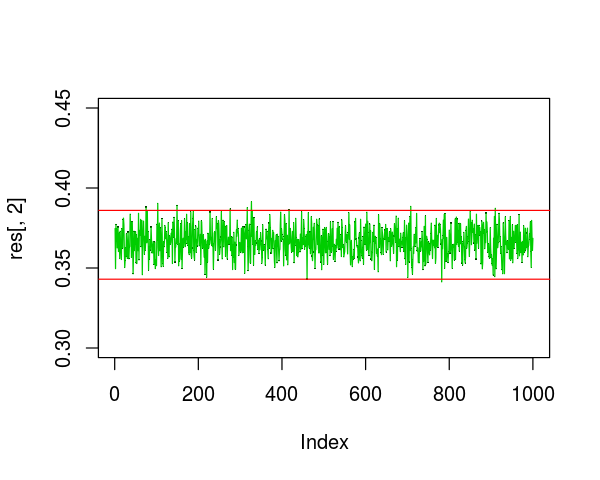

In [31]:
options(repr.plot.width=5, repr.plot.height=4)
plot(res[,2],ylim=c(0.3,0.45),pch='.')
lines(res[,2],col=3,pch='.')
abline(h=0.343,col=2)
abline(h=0.386,col=2)

Une fonction de la librairie `boot` fournit une estimation bootstrap de l'intervalle de confiance un peu longue à exécuter.

In [32]:
library(boot)
fc <- function(d, i){ 
    d2 <- d[i,]
    return(statistic=dispImp(d2$sex,d2$income)[2])
}
set.seed(11)
bootDI <- boot(datBas,fc, R=1000)
bootDI


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = datBas, statistic = fc, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.3666135 -0.0001896611 0.009193644

In [33]:
boot.ci(boot.out = bootDI, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootDI, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.3487,  0.3848 )  
Calculations and Intervals on Original Scale

Comme attendu, l'intervalle de confiance issu de l'approximation par *delta method*: $[0.349, 0.384]$ se confond avec  celui obtenu par estimation bootstrap: $[0.349, 0.385]$.

***NB*** Compte tenu des temps de calcul, l'estimation approchée de l'IC par *delta method* est à privilégier!

***Ajouter: comparaison avec la version d'IC*** de  Morris S., Lobsenz R. (2000)

### Effet disproportionné des prévisions 
Le même ratio ou impact disproportionné calculé sur les prévisions $g(X)$ de $Y$ plutôt que sur $Y$ mesure explicitement l'effet de la prévision. Il revient à tester l'égalité des taux de prévision favorable. 

La valeur seuil de la probabilité pour prédire le niveau de revenu est fixée par défaut à 0.5.

#### Régression logistique

In [34]:
Yhat=as.factor(pred.log>0.5)

In [35]:
round(dispImp(daTest[,"sex"],Yhat),3)

[1] 0.212 0.248 0.283

#### *Random Forest*

In [36]:
round(dispImp(daTest[,"sex"],pred.rf),3)

[1] 0.329 0.375 0.420

La prévision reproduit et même renforce significativement le biais social pour le sexe avec la régression logistique linéaire car les intervalles de confiance sont disjoints. En revanche, la discrimination n'est pas significative avec la régression logistique quadratique (cf. [calepin long]()), ni pour *random forest*, non linéaires. 

#### Effet disproportionné des prévisions sans la variable sensible sexe
L'approche très naïve qui consiste à supprimer la variable sensible du modèle n'a finalement pas d'effet sur le biais et donc le caractère discriminatoire de l'algorithme.

In [37]:
Yhat_g=as.factor(pred_g.log>0.5)
round(dispImp(daTest[,"sex"],Yhat_g),3)

[1] 0.232 0.269 0.305

De même que les erreurs de prévisions restent stables, l'effet disproportionné n'est pas statistiquement affecté par la suppression de la variable sensible du modèle. Le déterminisme social est plus fort que la présence de la variable sensible: *une femme travaille de toute façon moins ou de façon moins qualifiée quelque soit son niveau d'éducation*. La suppression de la variable sensible n'impacte donc pas la modélisation. 

La régression logistique linéaire renforce de façon importante voire statistiquement significative le bais déjà présent dans les données. Ce n'est pas le cas de *random forest* sur cet échantillon test.  Plus précisément, Friedler et al. (2019) mettent en oeuvre une comparaison exhaustive de plusieurs algorithmes de débiaisage sur 5 jeux de données publics dont celles issues du recensement `adultCensus`. Les résultats sont comparés avec ceux "*base line*" d'algorithmes d'apprentissage classique (SVM, logistique, arbre de décision, bayésien naïf). Les résultats affichés mettent en évidence une forte disparité des *DI* calculés pour ces différents algorithmes ainsi que pour différentes extractions d'échantillons tests.

Le [calepin long]() vérifie ces résultats en considérant (validation croisée *Monte Carlo*) 20 réplications de la séparation des échantillons d'apprentissage et de test sur lesquels sont entraînés trois algorithmes: logistique linéaire, arbre de décision, *random forest*, avant d'évaluer le DI observé sur la prévision de l'échantillon test. 

Comme attendu, la précision dépend fortement de l'algorithme choisie mais aussi, c'est important et moins attendu, l'estimation du *DI*. De façon relativement contre-intuitive, meilleure est la précision et moins le biais est renforcé par rapport à celui `DIbase` des données d'entraînement. Mais, pour un algorithme donné, le *DI* n'est pas corrélé à la précision sur un échantillon d'apprentissage.

**En résumé** les forêts aléatoire apportent deux avantages par rapport à la régression logistique: meilleure prévision et moindre discrimination mais au prix évidemment de l'interprétabilité.

**Attention** comme le rappelle Friedler et al. (2019) les résultats et conclusions peuvent changer d'un jeu de données à un autre. C'est déjà bien connu en ce qui concerne la précision de la prévision, il est nécessaire de l'intégrer dans la gestion du biais.

### Effet disproportionné *vs. Testing*
#### Enquête commanditée par la DARES
Le *testing* (Riach et Rich 2002) est une méthode usuelle déployée par la ([DARES](http://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/etudes-et-syntheses/dares-analyses-dares-indicateurs-dares-resultats/testing)) du Ministère du Travail permettant de détecter une discrimination *directe* généralement opérée par un humain (cf. [article Le Monde 2020](https://www.lemonde.fr/societe/article/2020/01/08/une-etude-montre-des-discriminations-a-l-embauche-significatives-en-fonction-de-l-origine_6025227_3224.html)). Il consiste à évaluer la variabilité d'une décision lorsque seule la modalité de la variable sensible est modifiée. 

Les calculs ci-dessous permettent de reproduire les résultats globaux de l'enquête.

In [38]:
origine.i=matrix(0,10000,1);reponse.i=matrix(0,10000,1)
origine.i[4536:8910]=1;origine.i[9376:10000]=1
reponse.i[8911:10000]=1
origine=factor(origine.i,labels=c("Maghreb","France"))
reponse=factor(reponse.i,labels=c("Negative","Positive"))
table(reponse, origine)

          origine
reponse    Maghreb France
  Negative    4535   4375
  Positive     465    625

In [39]:
100*465/5000;100*625/5000; 465/625

[1] 9.3

[1] 12.5

[1] 0.744

Les ratios sont bien ceux de l'enquête. Il y a de très nombreuses façons de les comparer afin de conclure ou non à une discirmination jugée significative. Que donne l'évaluation de l'effet disproportionné?

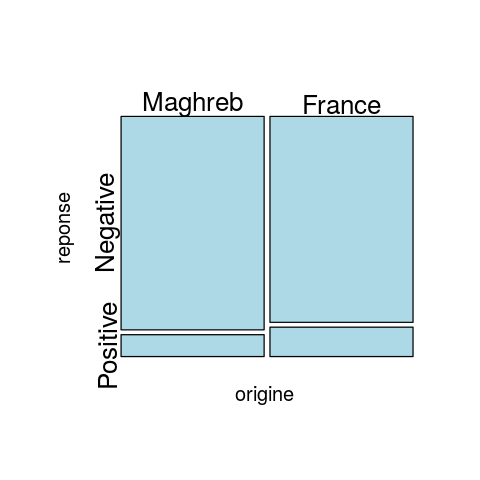

In [40]:
options(repr.plot.width=4, repr.plot.height=4)
mosaicplot(table(origine,reponse),main="",col="lightblue",cex=1.3)

In [41]:
round(dispImp(origine,reponse),3)

[1] 0.660 0.744 0.828

Globalement et au regard de la loi américaine, cette enquête de *testing*, par ailleurs sujette à de très nombreuses critiques, ne met pas en évidence une discrimination statistiquement significative. Bien entendu, il s'agit d'un résultat moyen et l'effet disproportionné peut l'être pour certaines entreprises. Attention, même avec 10 000 CVs envoyés, l'intervalle de confiance est relativement grand (14 points); pour une entreprise donnée recevant moins de CVs, celui-ci devrait être encore plus grand; la significativité statistique est difficile à assurer.

#### *Testing* d'un algorithme d'apprentissage
Que se passe-t-il si le *testing* est appliqué à une décision automatique pilotée par un algorithme d'apprentissage? 

Les prévisions de revenu sont calculées pour les mêmes personnes de l'échantillon test en prenant en compte le sexe initial puis le sexe opposé. Dans ce cas, une femme pour laquelle la prévision de revenu ou solvabilité change lorsque la variable sexe passe de `Female` à `Male` serait en droit d'intenter une action en justice pour discrimination directe. En revanche l'estimation de la dicrimination indirecte par ce procédé est nettement inadaptée.

In [42]:
daTest2=daTest
# Changement de genre
daTest2$sex=as.factor(ifelse(daTest$sex=="Male","Female","Male"))
# Prévision du "nouvel" échantillon test
pred2.log=predict(log.lm,daTest2,type="response")
Yhat2=as.factor(pred2.log>0.5)

In [43]:
table(Yhat,Yhat2)

       Yhat2
Yhat    FALSE TRUE
  FALSE  7081   23
  TRUE    155 1684

In [44]:
# répartition par genre
table(Yhat,Yhat2,daTest$sex)

, ,  = Female

       Yhat2
Yhat    FALSE TRUE
  FALSE  2679   23
  TRUE      0  195

, ,  = Male

       Yhat2
Yhat    FALSE TRUE
  FALSE  4402    0
  TRUE    155 1489


**N.B.** Il y a 178 personnes dont la prévision de revenu change lorsqu'elles changent de genre. Et le changement est dans le sens attendu.
- 23 femmes passent d'une prévision de revenu faible à une prévision de revenu élevé
- 155 hommes prennnent le chemin inverse  lorsqu'ils deviennent des femmes; ces hommes bénificient donc d'une discrimination positive.

Quels résultats fourniraient une enquête par testing consistant à envoyer deux fois les "dossiers" à l'algoritme, une fois pour chaque sexe. Il faut donc considérer deux fois plus de personnes en concaténant les deux prévisions. Ceci conduit à une table de contingence: . 

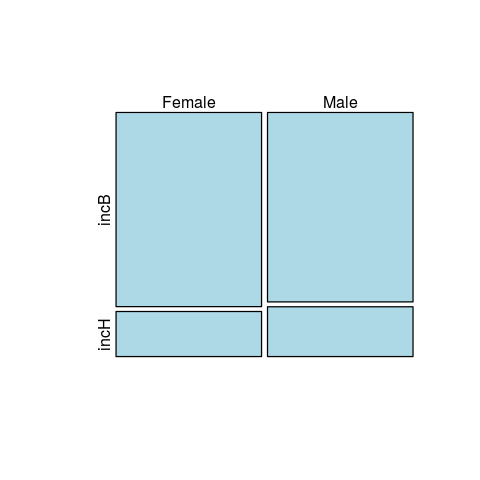

In [45]:
# fonction de concaténation de deux vecteurs de type factor
c.factor <- function(..., recursive=TRUE) unlist(list(...), recursive=recursive) 
Yhat=factor(Yhat,labels=c("incB","incH")); Yhat2=factor(Yhat2,labels=c("incB","incH"))
mosaicplot(table(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),main="",col="lightblue",cex=.8)

In [46]:
round(dispImp(c.factor(daTest$sex,daTest2[,"sex"]),c.factor(Yhat,Yhat2)),3)

[1] 0.851 0.904 0.958

Une conclusion très intuitive: le *testing* est adapté à détecter une discrimination directe, intentionnelle, opérée par un ou des humains envers un individu donné. Cette démarche sous-estime gravement la discrimination indirecte lorsqu'elle est cherche à évaluer un algorithme.

#### *Testing* et prévision "déloyale" 
Une façon simple pour une entreprise de se prémunir contre une opération de *testing* consiste à fixer comme probablité prédite le maximum des deux probablités obtenues en échangeant les modalités de la variable sensible. De façon générale, choisir la situation la plus favorable pour la personne quelque soit le sexe observé. La discrimination individuelle repérable par *testing* est neutralisée et l'influence sur le taux d'erreur quasi négligeable. 

In [47]:
fairPredictGenre=ifelse(pred.log<pred2.log,pred2.log,pred.log)
confMat=table(fairPredictGenre>0.5,daTest$income)
confMat;tauxErr(confMat)

       
        incB incH
  FALSE 6145  936
  TRUE   535 1327

[1] 16.45

In [48]:
round(dispImp(daTest$sex,as.factor(pred.log>0.5)),3)
round(dispImp(daTest$sex,as.factor(fairPredictGenre>0.5)),3)

[1] 0.212 0.248 0.283

[1] 0.240 0.277 0.314

Cette procédure masque de façon intentionnelle la discrimination directe tout en favorisant une discrimination indirecte, elle est clairement condamnable.

## Expliquer, atténuer la discrimination ?
De façon notable, le modèle de régression logistique reproduit le biais social et le renforce en introduisant donc de la discrimination; c'est moins net pour l'algorithme des forêts aléatoires,  Est-il possible d'expliquer ce comportement ou plus précisément d'utiliser le bon modèle ou bon algorithme qui l'évite? Le [calepin long]() compare différents algorithmes selon diverses situations notamment en attribuant sans succès plus de poids aux femmes afin de compenser leur sous-représentation. Une version plus efficace consiste à estimer deux modèles ou entrâiner deux algorithmes, l'un pour les femmes et l'autre pour les hommes dans les deux cas de la régression logistique et des forêts aléatoires.

### Séparation des deux échantillons
Les échantillons sont séparés en deux parties.

In [49]:
datAppF=datApp[datApp[,"sex"]=='Female',]
datAppM=datApp[datApp[,"sex"]=='Male',]
daTestF=daTest[daTest[,"sex"]=='Female',]
daTestM=daTest[daTest[,"sex"]=='Male',,]
summary(datAppM)

      age           educNum               mariStat              occup      
 Min.   :18.00   Min.   : 1.00   Married      :15053   Admin       : 1448  
 1st Qu.:30.00   1st Qu.: 9.00   Never-Married: 6286   Blue-Collar :10508  
 Median :38.00   Median :10.00   Not-Married  : 2684   Other-occups: 1366  
 Mean   :39.49   Mean   :10.16   Widowed      :  196   Professional: 3038  
 3rd Qu.:48.00   3rd Qu.:13.00                         Sales       : 2768  
 Max.   :90.00   Max.   :16.00                         Service     : 1657  
                                                       White-Collar: 3434  
    origEthn         sex          hoursWeek      income       LcapitalGain    
 CaucNo : 2767   Female:    0   Min.   : 1.00   incB:16599   Min.   : 0.0000  
 CaucYes:21452   Male  :24219   1st Qu.:40.00   incH: 7620   1st Qu.: 0.0000  
                                Median :40.00                Median : 0.0000  
                                Mean   :43.06                Mean   : 0.8756

### Régression logistique

In [50]:
# Modèle linéaire
reg.log=glm(income~.,data=datApp,family=binomial)
# estimation des deux modèles
reg.logF=glm(income~.,data=datAppF[,-6],family=binomial)
reg.logM=glm(income~.,data=datAppM[,-6],family=binomial)
# comparaison des paramètres
summary(reg.logF);summary(reg.logM)


Call:
glm(formula = income ~ ., family = binomial, data = datAppF[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7599  -0.3155  -0.1702  -0.0857   3.2486  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -6.630302   0.329682 -20.111  < 2e-16 ***
age                    0.028243   0.003632   7.776 7.51e-15 ***
educNum                0.344333   0.022115  15.570  < 2e-16 ***
mariStatNever-Married -3.234358   0.109992 -29.405  < 2e-16 ***
mariStatNot-Married   -3.184526   0.104019 -30.615  < 2e-16 ***
mariStatWidowed       -3.084459   0.186985 -16.496  < 2e-16 ***
occupBlue-Collar      -0.271436   0.170624  -1.591   0.1116    
occupOther-occups      0.460846   0.179814   2.563   0.0104 *  
occupProfessional      0.506472   0.123034   4.117 3.85e-05 ***
occupSales             0.046678   0.150410   0.310   0.7563    
occupService          -0.837763   0.168564  -4.970 6.70e-07 ***
occupWhite-Collar      0


Call:
glm(formula = income ~ ., family = binomial, data = datAppM[, 
    -6])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7789  -0.6783  -0.2519   0.6406   3.5811  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -5.687860   0.168043 -33.848  < 2e-16 ***
age                    0.023581   0.001582  14.902  < 2e-16 ***
educNum                0.274213   0.008997  30.480  < 2e-16 ***
mariStatNever-Married -2.206630   0.068750 -32.097  < 2e-16 ***
mariStatNot-Married   -1.618886   0.065785 -24.609  < 2e-16 ***
mariStatWidowed       -1.405521   0.213035  -6.598 4.18e-11 ***
occupBlue-Collar      -0.374446   0.078316  -4.781 1.74e-06 ***
occupOther-occups      0.346870   0.097294   3.565 0.000364 ***
occupProfessional      0.345929   0.087351   3.960 7.49e-05 ***
occupSales             0.124214   0.086388   1.438 0.150472    
occupService          -1.123745   0.132553  -8.478  < 2e-16 ***
occupWhite-Collar      0

In [51]:
# prévision des modèles
yHat=predict(reg.log,newdata=daTest,type="response")
yHatF=predict(reg.logF,newdata=daTestF,type="response")
yHatM=predict(reg.logM,newdata=daTestM,type="response")
# compilation des prévisions
yHatFM=c(yHatF,yHatM)

In [52]:
daTestFM=rbind(daTestF,daTestM)
dim(daTestFM)

[1] 8943   11

In [53]:
# erreurs cumulées
table(yHatFM>0.5,daTestFM$income)

       
        incB incH
  FALSE 6150  935
  TRUE   530 1328

In [54]:
table(yHat>0.5,daTest$income)

       
        incB incH
  FALSE 6154  950
  TRUE   526 1313

In [55]:
tauxErr(table(yHatFM>0.5,daTestFM$income))

[1] 16.38

In [56]:
tauxErr(table(yHat>0.5,daTest$income))

[1] 16.5

On retrouve le taux d'erreur précédent pour la régression logistique, c'est le même modèle, tandis que l'association des deux modèles conduit à une erreur un peu plus faible en intégrant l'interaction du sexe avec les autres variables.

In [57]:
# biais cumulés vs. biais 
round(dispImp(daTestFM[,"sex"],as.factor(yHatFM>0.5)),3); round(dispImp(daTest[,"sex"],as.factor(yHat>0.5)),3)

[1] 0.284 0.324 0.365

[1] 0.212 0.248 0.283

In [58]:
# Rappel: Biais de la base de test
round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.339 0.379 0.419

Le biais est significativement plus faible pour l'association des deux modèles qui prend en compte les interactions du sexe avec les autres variables mais reste plus important que celui initial de la base.

### *Random Forest*

In [59]:
library(randomForest)
# Modèle initial
RFinit=randomForest(income~.,data=datApp)
# Modèle en changeant les poids
RFinitW=randomForest(income~.,data=datApp,weigth=w)
# estimation des deux modèles
RF.F=randomForest(income~.,data=datAppF[,-6])
RF.M=randomForest(income~.,data=datAppM[,-6])
# comparaison des paramètres

In [60]:
# prévision des modèles
yHatrf=predict(RFinit,newdata=daTest,type="response")
yHatrfW=predict(RFinitW,newdata=daTest,type="response")
yHatFrf=predict(RF.F,newdata=daTestF,type="response")
yHatMrf=predict(RF.M,newdata=daTestM,type="response")
# compilation des prévisions
yHatFMrf=c(yHatFrf,yHatMrf)

In [61]:
# erreurs cumulées vs. erreur initiale de RF
table(yHatFMrf,daTestFM$income); table(yHatrf,daTest$income)

        
yHatFMrf incB incH
    incB 6275  871
    incH  405 1392

      
yHatrf incB incH
  incB 6292  862
  incH  388 1401

In [62]:
tauxErr(table(yHatFMrf,daTestFM$income)); tauxErr(table(yHatrf,daTest$income))
tauxErr(table(yHatrfW,daTest$income))

[1] 14.27

[1] 13.98

[1] 13.98

In [63]:
# Biais cumulé vs. biais du modèle initial vs. biais de la base
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrf)),3);round(dispImp(daTest[,"sex"],as.factor(yHatrf)),3);
round(dispImp(daTest[,"sex"],as.factor(yHatrfW)),3);round(dispImp(daTestFM[,"sex"],daTestFM[,"income"]),3)

[1] 0.351 0.398 0.445

[1] 0.323 0.368 0.413

[1] 0.314 0.358 0.403

[1] 0.339 0.379 0.419

### Atténuation de la discrimiation
De très nombreux adaptations on été proposées (cf. les tutoriels du site [AIF360](https://aif360.mybluemix.net/)) afin de réduire ou atténuer la discrimination d'un algorithme d'apprentissage. La procédure la plus simple illustrée ci-dessous consiste à introduire une forme de discrimination positive en intervenant sur le seuil de décision pour les femmes tout en conservant celui de 0.5 pour les hommes.

In [64]:
# prévision des modèles
yHatFrfDP=predict(RF.F,newdata=daTestF,type="prob")[,1]<0.7
yHatMrfDP=predict(RF.M,newdata=daTestM,type="prob")[,1]<0.5
# compilation des prévisions
yHatFMrfDP=c(yHatFrfDP,yHatMrfDP)

In [65]:
table(yHatFMrfDP,daTestFM$income)

          
yHatFMrfDP incB incH
     FALSE 6193  834
     TRUE   487 1429

In [66]:
tauxErr(table(yHatFMrfDP,daTestFM$income))

[1] 14.77

In [67]:
round(dispImp(daTestFM[,"sex"],as.factor(yHatFMrfDP)),3)

[1] 0.507 0.563 0.619

### Synthèse graphique des résultats
Les résultats précédents: précisions et intervalles de confiance sont collectés et affichés sur le même graphique.

In [68]:
diAlgos=read.table("diVSalgos-red.txt",header=T)
diAlgos

Model,Lower,DI,Upper,Accuracy
dataBaseBias,0.339,0.379,0.419,100.00
linLogit,0.212,0.248,0.283,83.50
linLogit_w_S,0.232,0.269,0.305,83.50
testingLogit,0.850,0.900,0.960,83.50
randomForest,0.318,0.363,0.407,85.98
RFdiscrPos,0.506,0.562,0.619,85.24


Loading required package: prodlim


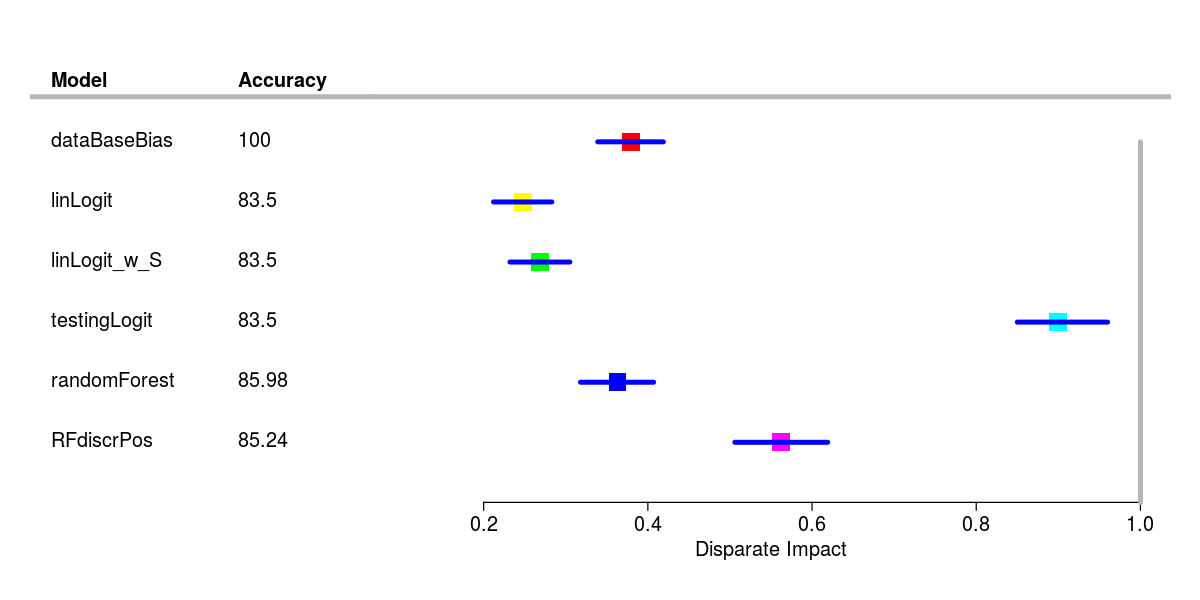

In [69]:
library(Publish)
options(repr.plot.width=10, repr.plot.height=5)
plotConfidence(x=diAlgos[,c("DI","Lower","Upper")],labels=diAlgos[,c("Model","Accuracy")],
               points.pch=15,points.cex=3,points.col=rainbow(6),
              values=FALSE,xlim=c(0.1,1),lwd=4,cex=1.5,
               xlab="Disparate Impact",xlab.cex=1,xratio=0.3,y.title.offset=1)

**Commentaires**
- `dataBaseBias` les données initiales sont largement biaisées
- `linLogit` un modèle de régression logistique linéaire exacerbe le biais et donc discrimine de façon statistiquement significative: les intervalles de confiance sont disjoints.
- `linLOgit_w_ S` un modèle de régression logistique sans la variable sexe discrimine tout autant. Retirer la variable sensible d'un modèle ou, en amont, d'une base de données est une fausse bonne idée.
- `testingLogit` comme le sexe est inclus dans les autres variables, le testing ne détecte pas de discrimination. 
- `randomForest` un algorithme non linéaire n'augmente pas de façon significative le biais statistique, il ne discriminae pas, mais c'est au prix de l'interprétabilité ou de l'explicabilité d'une décision.
- `RFdiscrPos` il est facile d'introduire un peu de discrimination positive pour atténuer le biais de société sans dégradé la précision.

## Autres indicateurs de biais / discrimination
### Biais sur les erreurs ou précisions de prévision conditionnelles
L'effet disproportionné est une première source de biais ou de discrimination parmi bien d'autres. Une deuxième souvent évoquée concerne les erreurs de prévision ou les précisions selon les modalités de la variable sensible; c'est  l'*overall error equality* ou de façon équivalente l'*overall accuracy equality*.

#### Régression logistique linéaire
*Overall error equality*

In [70]:
table(pred.log>0.5,daTest$income,daTest$sex)

, ,  = Female

       
        incB incH
  FALSE 2497  205
  TRUE    52  143

, ,  = Male

       
        incB incH
  FALSE 3657  745
  TRUE   474 1170


In [71]:
apply(table(pred.log>0.5,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  8.87  20.16

Les erreurs sont au détriment des hommes. Le ration est également estimé par un intervalle de confiance.

In [72]:
source('../Functions/overErrEqual.R')

In [76]:
round(overErrEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
OEE,0.38,0.44,0.5


#### Random forest
Cet algorithme conduit à des disparités similaires et même plus marquées entre les deux genres.

In [77]:
apply(table(yHatrf,daTest$income,daTest$sex),3,tauxErr)

Female   Male 
  7.04  17.30

In [78]:
round(overErrEqual(daTest$sex,daTest$income,yHatrf),2)

,inf,est_value,sup
OEE,0.35,0.41,0.47


#### *Random forest* avec discrimination positive
Atténuer la discrimination n'influence pas nettement les aux d'erreur.

In [79]:
tauxErr(table(yHatFrfDP,daTestF$income)); tauxErr(table(yHatMrfDP,daTestM$income))

[1] 8.8

[1] 17.63

In [80]:
round(overErrEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

,inf,est_value,sup
OEE,0.43,0.5,0.56


Quel que soit l'algorithme utilisé, la disparité reste importante entre les genre avec un taux d'erreur significativmeent plus important pour les hommes. En introduisant une par t de discrimination positive pour atténuer la discrimination envers les femmes, le taux d'erreur augmente logiquement.

### Asymétrie de la matrice de confusion: *equality of odds* 
Une autre source de discrimination est considére. Elle a été mise en exergue par le site [Propublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) à propos du score de récidive COMPAS de la société *equivant* utilisé dans certaines cours de justice américaines sous une forme de "justice prédictive". Le biais concerne une inversion de l'asymétrie de la matrice de confusion selon la variable sensible. De très nombreux critères ont été proposés pour évaluer cette asymétrie et dont [Verma et Rubin (2018](http://fairware.cs.umass.edu/papers/Verma.pdf)) proposent une revue. Leurs définitions sont basées sur les différentes fréquences issues de la table de contingence et calculées par la fonction ci-dessous.

In [81]:
contRatio <- function(T){ 
    # Ratios calculés à partir de la matrice de confusion
    TP=T[2,2] # true positive
    FP=T[2,1] # false positive
    FN=T[1,2] # false negative
    TN=T[1,1]  # true negative
    PPV=TP/(TP+FP) # P(Y=1|g(x)=1) positive predictive value
    FDR=FP/(TP+FP) # P(Y=0|g(x)=1) false discovery rate 
    FOR=FN/(TN+FN) # P(Y=1|g(x)=0) false omission rate
    NPV=TN/(TN+FN) # P(Y=0|g(x)=0) negative predictive value
    TPR=TP/(TP+FN) # P(g(x)=1|Y=1) true positive rate
    FPR=FP/(FP+TN) # P(g(x)=1|Y=0) false positive rate
    FNR=FN/(TP+FN) # P(g(x)=0|Y=1) false negative rate
    TNR=TN/(FP+TN) # P(g(x)=0|Y=0) true negative rate
    return(list("PPV"=PPV,"FDR"=FDR,"FOR"=FOR,"NPV"=NPV,"TPR"=TPR,"FPR"=FPR,"FNR"=FNR,"TNR"=TNR))
}

In [82]:
contRatio(table(pred.log>0.5,daTest$income))

$PPV
[1] 0.713975

$FDR
[1] 0.286025

$FOR
[1] 0.1337275

$NPV
[1] 0.8662725

$TPR
[1] 0.5802033

$FPR
[1] 0.07874251

$FNR
[1] 0.4197967

$TNR
[1] 0.9212575

Liste de critères d'équité pouvant être définis à partir des fréquences précédentes conditionnellement à la variable sensible. La combinatoire des possibles est importante mais peut être réduite en remarquant que *PPV*=1-*FDR*, *FOR*=1-*NPV*, *FPR*=1-*TNR*, *FNR*=1-*TPR*... Selon les auteurs, il y a équité de traitement si:
- *Predictive parity*: les deux groupes ont les mêmes *PPV*s et par conséquence les mêmes *FDR*s;
- *False positive error rate balance* ou *predictive equality*: mêmes *FPR*s et par conséquence les mêmes *TNR*s;
- *False negative error rate balance* ou *equal opportunity*: mêmes *FNR*s et par conséquence les mêmes *TPR*s;
- *Conditional procedure accuracy equality* ou *disparate mistreatment* ou *equalized odds* combine les deux ci-dessus: mêmes *TPR*s **ET** mêmes *FPR*s;
- *Overall accuracy equality*: mêmes *TPR* **ET** mêmes *TNR*;
- *Conditionnal use accuracy equality*: mêmes *PPV*s **ET** mêmes *NPV*s;
- *Teatment equality*: les rapports *FN/FP* sont les mêmes pour les deux groupes.

Bien d'autres critères ont été proposés (cf. Verma et Rubin; 2018), il ne sont pas développés ici. Les calculs des *TPR* et *TNR* conditionnels sont privilégiés ci-dessous mais ce n'est qu'un choix parmi d'autres. Friedler et al. (2019) montrent que ceux-ci sont très corrélés. il serait raisonnable de se limiter aux seules comparaisons des *TPR* et *FPR*.

#### Régression logistique linéaire
La matrice de confusion est construite pour chaque genre pour comparer les différents indicateurs de loyauté.

In [83]:
fairness=data.frame("Female"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(pred.log>0.5,daTest$income,daTest$sex)[,,2])))
fairness

,Female,Male
PPV,0.7333333,0.7116788
FDR,0.2666667,0.2883212
FOR,0.07586973,0.1692413
NPV,0.9241303,0.8307587
TPR,0.4109195,0.6109661
FPR,0.02040016,0.1147422
FNR,0.5890805,0.3890339
TNR,0.9795998,0.8852578


Il serait fastidieux de construire toutes les comparaisons d'autant que beaucoup de ces indicateurs sont redondants. Seuls les  ***Equality of Odds*** sont estimés par des intervalles de  confiance à l'aide de la fonciton `oddsEqual` qui  admet 4 paramètres:
- S: variable du groupe protégé
- Y: variable cible
- P: prévision $\hat{Y}$
- alpha=0.05, valeur par défaut.

Elle fournit l'estimation par intervalle de confiance des rapports des *FPR* et *TPR* conditionnels et permet donc de tester l'égalité ou non des cotes selon la variable sensible.

In [84]:
source('../Functions/oddsEqual.R')

In [85]:
round(oddsEqual(daTest$sex,daTest$income,as.factor(pred.log>0.5)),2)

,inf,est_value,sup
FPR,0.13,0.18,0.23
TPR,0.58,0.67,0.76


#### *Random forest* 

In [86]:
fairnessRF=data.frame("Female"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,1])),
                    "Male"=as.matrix(contRatio(table(yHatrf,daTest$income,daTest$sex)[,,2])))
fairnessRF

,Female,Male
PPV,0.7686567,0.7856673
FDR,0.2313433,0.2143327
FOR,0.05401293,0.159116
NPV,0.9459871,0.840884
TPR,0.591954,0.6240209
FPR,0.02432326,0.07891552
FNR,0.408046,0.3759791
TNR,0.9756767,0.9210845


In [87]:
round(oddsEqual(daTest$sex,daTest$income,yHatrf),2)

,inf,est_value,sup
FPR,0.23,0.31,0.39
TPR,0.86,0.95,1.04


#### *Random forest* avec discrimination positive

In [88]:
fairnessRFDP=data.frame("Female"=as.matrix(contRatio(table(yHatFrfDP,daTestF$income))),
                    "Male"=as.matrix(contRatio(table(yHatMrfDP,daTestM$income))))
fairnessRFDP

,Female,Male
PPV,0.6142506,0.7813121
FDR,0.3857494,0.2186879
FOR,0.03935743,0.1622217
NPV,0.9606426,0.8377783
TPR,0.7183908,0.6156658
FPR,0.06159278,0.07988381
FNR,0.2816092,0.3843342
TNR,0.9384072,0.9201162


In [89]:
round(oddsEqual(daTestFM[,"sex"],daTestFM$income,as.factor(yHatFMrfDP)),2)

,inf,est_value,sup
FPR,0.63,0.77,0.91
TPR,1.08,1.17,1.25


## Discussion

Le traitement de ce jeu de données montre clairement qu'un modèle linéaire de prévision peut renforcer ou exacerber un biais de société déjà présent dans les données. Il opère donc une discrimination dont la significativité statistique est détectée par des estimations par intervalles de confiance mais pas du tout par une enquête par *testing*. Ainsi, en France et dans le cas d'algorithmes d'aide à l'embauche, une enquête par *testing* comme le pratique la DARES ne détectera rien au contraire de statistiques calculées *ex-post*; les entreprises de recrutement prédictif ne se préoccupe pas de ces "détails" contrairement à ce qui se passe aux USA où le calcul de l'*adverse* ou *disparate impact* est pris en compte par applications juridiques du code du travail.

Le choix d'un algorithme non linéaire semble préférable pour éviter de surbiaiser mais, aux USA, c'est risqué car le biais reste important mais sans explication donc justification possible. C'est sans doute la raison pour laquelle les entreprises américaines de la *hiring tech* propose des atténations du biais afin d'économiser des poursuites judiciaires (Raghavan et al. 2019).

D'autres niveaux de biais sont également à considérer. Tous les algorithmes semblent "favoriser" les femmes avec des taux d'erreur plus faibles les concernant mais l'analyse précises des matrices de confusion montre que c'est finalement à leur détriment; si les hommes ont des taux d'erreur plus importants c'est surtout par des taux de faux positifs plus élevés que pour les femmes alors que les taux de faux négatifs sont moins élevés. Les algorithmes se trompent plus pour eux mais pour des décisions qui finalement les avantagent. 

L'algorithme qui introduit une discrimination positive en intervenant sur le seuil de décision des femmes ne modifie pas le taux d'erreur des hommes mais ré-équilibre en partie les matrices de confusion et modère donc ce dernier biais. 

Un `data scientist` dispose actuellement d'une grande latitude pour faire ce qu'il veut, du comportement déloyal à la discrimination positive. Nous pouvons espérer qu'après la mise en palce du RGPD, la Commission Européenne interviennent également sur ces questions. C'est en tous cas le sens des directives annoncées dans le [livre blanc](https://ec.europa.eu/info/sites/info/files/commission-white-paper-artificial-intelligence-feb2020_fr.pdf).

## Références
Barocas S., Selbst A. (2016). [Big Data's Disparate Impact](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2477899), *California Law Review*, 671.

Besse P., del Barrio E., Gordaliza P., Loubes J.-M. (2018). [Confidence Intervals for testing Disparate Impact in Fair Learning](https://arxiv.org/abs/1807.06362), arXiv preprint.

Efron B. (1987). [Better Bootstrap Confidence Intervals](https://www.jstor.org/stable/2289144?seq=1), *Journal of the American Statistical Association*, Vol. 82, No. 397 (Mar., 1987), pp. 171-185. 

Friedler S., Scheidegger C., Venkatasubramanian S., Choudhary S., Hamilton E., Roth D. (2019). [A comparative study of fairness-enhancing interventions in machine learning](https://dl.acm.org/doi/10.1145/3287560.3287589), *Proceedings of the Conference on Fairness, Accountability, and Transparency*.

Morris S., Lobsenz R. (2000), [Signifiance Tests and Confidence Intervals for the Adverse Impact Ratio](https://doi.org/10.1111/j.1744-6570.2000.tb00195.x) *Personnel Psychology*, 53: 89-111.

Riach, P., Rich J. (2002). [Field Experiments of Discrimination In The Market Place]( https://doi.org/10.1111/1468-0297.00080), *The Economic Journal*, Vol. 112, 480-518.

Raghavan M., Barocas S., Kleinberg J., Levy K. (2019) [Mitigating bias in Algorithmic Hiring : Evaluating Claims and Practices](https://arxiv.org/abs/1906.09208), arXiv:1906.09208.

Verma S., Rubin J. (2018). [Fairness Definitions Explained](http://fairware.cs.umass.edu/papers/Verma.pdf),  *ACM/IEEE International Workshop on Software Fairness*.

Zliobaitė I. (2015). [A survey on measuring indirect discrimination in machine learning](https://arxiv.org/pdf/1511.00148.pdf), arXiv preprint.
